In [1]:
# Import dependencies
import pandas as pd
from datetime import date
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Save lockdown data to dataframe
lockdown_link = 'data/covid_lockdown.csv'
lockdown_data = pd.read_csv(lockdown_link)
lockdown_data.tail()

,Countries and territories,Place,Start date,End date,Level
115,United States,New York,3/20/2020,5/15/2020,State
116,United States,Oregon,3/24/2020,NaN,State
117,United States,Wisconsin,3/24/2020,NaN,State
118,Venezuela,NaN,3/17/2020,5/13/2020,National
119,Zimbabwe,NaN,3/30/2020,5/2/2020,National


In [3]:
# To make calculations easier, replace any TBD or NaN in 'End date' with today's date.
today = str(date.today())

lockdown_data['End date'] = lockdown_data['End date'].fillna(today)
lockdown_data['End date'] = lockdown_data['End date'].str.replace(pat = 'TBD', repl= today)

In [4]:
# Apply median incubation period (5 days) to lockdown start date in order to see effectiveness of lockdown
incubation_period = timedelta(days=5)
lockdown_data['Lock Effect Start'] = pd.to_datetime(lockdown_data['Start date']) + incubation_period
lockdown_data['Lock Effect End'] = pd.to_datetime(lockdown_data['End date']) + incubation_period
lockdown_data.tail()

,Countries and territories,Place,Start date,End date,Level,Lock Effect Start,Lock Effect End
115,United States,New York,3/20/2020,5/15/2020,State,2020-03-25,2020-05-20
116,United States,Oregon,3/24/2020,2020-05-08,State,2020-03-29,2020-05-13
117,United States,Wisconsin,3/24/2020,2020-05-08,State,2020-03-29,2020-05-13
118,Venezuela,NaN,3/17/2020,5/13/2020,National,2020-03-22,2020-05-18
119,Zimbabwe,NaN,3/30/2020,5/2/2020,National,2020-04-04,2020-05-07


In [5]:
# For countries that have more than one 'place', only keep the first entry
index = []
for country in range(1, len(lockdown_data['Countries and territories'])):
    if lockdown_data['Countries and territories'][country] == lockdown_data['Countries and territories'][country -1]:
        index.append(country)
lock_data = lockdown_data.drop(lockdown_data.index[index])
lock_data.head()

,Countries and territories,Place,Start date,End date,Level,Lock Effect Start,Lock Effect End
0,Albania,NaN,3/13/2020,2020-05-08,National,2020-03-18,2020-05-13
1,Algeria,Algiers,3/23/2020,4/19/2020,City,2020-03-28,2020-04-24
3,Argentina,NaN,3/19/2020,5/10/2020,National,2020-03-24,2020-05-15
4,Armenia,NaN,3/24/2020,4/14/2020,National,2020-03-29,2020-04-19
5,Australia,NaN,3/23/2020,2020-05-08,National,2020-03-28,2020-05-13


In [6]:
# Save Worldwide Covid data to dataframe
cov_link = 'data/world_covid.csv'
cov_data = pd.read_csv(cov_link)
cov_data.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,04/05/2020,4,5,2020,235,13,Afghanistan,AF,AFG,37172386.0,Asia
1,03/05/2020,3,5,2020,134,4,Afghanistan,AF,AFG,37172386.0,Asia
2,02/05/2020,2,5,2020,164,4,Afghanistan,AF,AFG,37172386.0,Asia
3,01/05/2020,1,5,2020,222,4,Afghanistan,AF,AFG,37172386.0,Asia
4,30/04/2020,30,4,2020,122,0,Afghanistan,AF,AFG,37172386.0,Asia


In [7]:
# Left merge dataframes keeping the world covid data in tact
left_merge = cov_data.merge(lock_data, how='left', left_on='countriesAndTerritories', right_on='Countries and territories')

In [8]:
# Drop unneeded columns
left_merge = left_merge[['countriesAndTerritories', 'dateRep', 'cases', 'deaths', 'popData2018', 'Lock Effect Start', 'Lock Effect End']]

# Create boolean lockdown column and set to false when 'lockdown effective' is NaN
left_merge['Lockdown'] = pd.notnull(left_merge['Lock Effect Start'])

# Sets datatype of dates to datetime
left_merge['dateRep'] = pd.to_datetime(left_merge['dateRep'], infer_datetime_format=True)
left_merge['Lock Effect End'] = pd.to_datetime(left_merge['Lock Effect End'], infer_datetime_format=True)


In [12]:
# Loop and conditional to replace boolean lockdown values if the lockdown date falls outside the lockdown effective period
for date in range(len(left_merge['dateRep'])):
    if (left_merge['Lockdown'][date] == True) & ((left_merge['dateRep'][date] < left_merge['Lock Effect Start'][date]) | (left_merge['dateRep'][date] > left_merge['Lock Effect End'][date])):
        left_merge.at[date, 'Lockdown'] = False
left_merge.tail(50)


# After looking at the data closer, it seems there is a data entry problem in the source code.
# At one point it seems like they switched the day and month values in the dateRep column by mistake.

,countriesAndTerritories,dateRep,cases,deaths,popData2018,Lock Effect Start,Lock Effect End,Lockdown
14816,Zambia,2020-03-23,1,0,17351822.0,NaT,NaT,False
14817,Zambia,2020-03-22,0,0,17351822.0,NaT,NaT,False
14818,Zambia,2020-03-21,0,0,17351822.0,NaT,NaT,False
14819,Zambia,2020-03-20,0,0,17351822.0,NaT,NaT,False
14820,Zambia,2020-03-19,2,0,17351822.0,NaT,NaT,False
14821,Zimbabwe,2020-04-05,0,0,14439018.0,2020-04-04,2020-05-07,True
14822,Zimbabwe,2020-03-05,0,0,14439018.0,2020-04-04,2020-05-07,False
14823,Zimbabwe,2020-02-05,0,0,14439018.0,2020-04-04,2020-05-07,False
14824,Zimbabwe,2020-01-05,0,0,14439018.0,2020-04-04,2020-05-07,False
14825,Zimbabwe,2020-04-30,2,0,14439018.0,2020-04-04,2020-05-07,True


In [60]:
group_sum = left_merge.groupby(['countriesAndTerritories', 'Lockdown'])[['cases', 'deaths']].sum()
group_sum.head(15)

cases  deaths
countriesAndTerritories Lockdown               
Afghanistan             False      2704      85
Albania                 False       228       9
                        True        567      22
Algeria                 False      2709     275
                        True       1765     188
Andorra                 False       748      45
Angola                  False        35       2
Anguilla                False         3       0
Antigua_and_Barbuda     False        25       3
Argentina               False      1514      83
                        True       3256     163
Armenia                 False      1766      21
                        True        620      14
Aruba                   False       100       2
Australia               False      4452      42

In [68]:
group_mean = left_merge.groupby(['countriesAndTerritories', 'Lockdown']).mean()
group_mean.head(15)

cases    deaths  popData2018
countriesAndTerritories Lockdown                                   
Afghanistan             False      23.310345  0.732759   37172386.0
Albania                 False      10.363636  0.409091    2866376.0
                        True       16.200000  0.628571    2866376.0
Algeria                 False      27.090000  2.750000   42228429.0
                        True       84.047619  8.952381   42228429.0
Andorra                 False      14.384615  0.865385      77006.0
Angola                  False       0.795455  0.045455   30809762.0
Anguilla                False       0.076923  0.000000          NaN
Antigua_and_Barbuda     False       0.543478  0.065217      96286.0
Argentina               False      52.206897  2.862069   44494502.0
                        True      108.533333  5.433333   44494502.0
Armenia                 False      17.145631  0.203883    2951776.0
                        True       44.285714  1.000000    2951776.0
Aruba                   False       2.325581  0.046512     105845.0
Australia               False      46.863158  0.442105   24992369.0

In [27]:
left_merge[['cases', 'deaths']].describe()

,cases,deaths
count,14866.000000,14866.000000
mean,233.238329,16.613682
std,1611.790547,123.954216
min,-1430.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,30.000000,1.000000
max,48529.000000,4928.000000


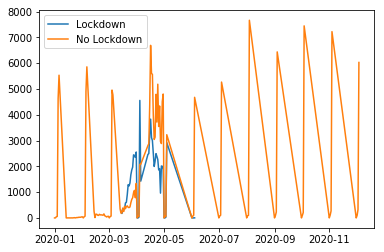

In [87]:
plt.plot(left_merge[left_merge['Lockdown'] == True].groupby(['dateRep'])['deaths'].sum(), label='Lockdown')
plt.plot(left_merge[left_merge['Lockdown'] == False].groupby(['dateRep'])['deaths'].sum(), label='No Lockdown')
plt.title('Sum of Deaths Over Time; Lockdown vs No Lockdown')
plt.legend()
plt.show()

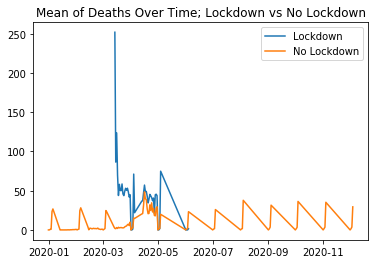

In [95]:
plt.plot(left_merge[left_merge['Lockdown'] == True].groupby(['dateRep'])['deaths'].mean(), label='Lockdown')
plt.plot(left_merge[left_merge['Lockdown'] == False].groupby(['dateRep'])['deaths'].mean(), label='No Lockdown')
plt.title('Mean of Deaths Over Time; Lockdown vs No Lockdown')
plt.legend()
plt.show()

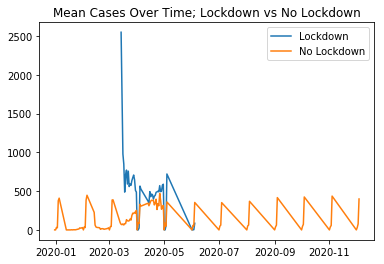

In [94]:
plt.plot(left_merge[left_merge['Lockdown'] == True].groupby(['dateRep'])['cases'].mean(), label='Lockdown')
plt.plot(left_merge[left_merge['Lockdown'] == False].groupby(['dateRep'])['cases'].mean(), label='No Lockdown')
plt.title('Mean Cases Over Time; Lockdown vs No Lockdown')
plt.legend()
plt.show()

In [96]:
mean_deaths = left_merge['deaths'].mean()
mean_cases = left_merge['cases'].mean()
mean_pop = left_merge['popData2018'].mean()
death_per_case = mean_deaths / mean_cases
cases_per_pop = mean_cases / mean_pop
print('Ratio of mean deaths per mean positive cases: {}'.format(death_per_case))
print('Ratio of mean positve cases per average population: {}'.format(cases_per_pop))

Ratio of mean deaths per mean positive cases: 0.07123049755127951
Ratio of mean positve cases per average population: 4.283447837914493e-06


In [ ]:
# Create a subgroup comparing dates just before lockdown to dates just after the effects of the lockdown can be seen

#obs_period = timedelta(days=7)           #observation period

#indexed_merge = left_merge.set_index(keys=['countriesAndTerritories', 'Lockdown'])
#indexed_merge = indexed_merge.sort_values(['countriesAndTerritories', 'Lockdown','cases'])
#indexed_merge